# Geometry Validation Dashboard

Run `make geometry-data` (or `make all`) from `python/validation` to refresh the JSON artifacts under `python/validation/artifacts/geometry_data/`, then execute the cells below to inspect epsilon(r) snapshots and fill-fraction metrics for each lattice preset.


In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np

NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / 'artifacts' / 'geometry_data'
print(f'Reading geometry reports from {DATA_DIR}')

def load_reports():
    reports = []
    for path in sorted(DATA_DIR.glob('geometry_*.json')):
        with path.open() as fp:
            payload = json.load(fp)
        payload['artifact_path'] = path
        payload['grid_array'] = np.array(payload['grid'])
        reports.append(payload)
    if not reports:
        raise FileNotFoundError(
            'No geometry validation JSON artifacts present. Run make geometry-data first.'
        )
    return reports

reports = load_reports()
summary = pd.DataFrame({
    'lattice': [r['lattice'] for r in reports],
    'resolution': [r['resolution'] for r in reports],
    'eps_bg': [r['eps_bg'] for r in reports],
    'eps_inside': [r['eps_inside'] for r in reports],
    'expected_fill': [r['expected_fill_fraction'] for r in reports],
    'measured_fill': [r['measured_fill_fraction'] for r in reports],
    'fill_delta': [r['fill_fraction_error'] for r in reports],
    'artifact': [str(r['artifact_path']) for r in reports],
})
summary


Reading geometry reports from /home/renlephy/mpb-gpu-2D/python/validation/artifacts/geometry_data


,lattice,resolution,eps_bg,eps_inside,expected_fill,measured_fill,fill_delta,artifact
0,square,128,16.0,4.0,0.125664,0.125488,-0.000175,/home/renlephy/mpb-gpu-2D/python/validation/ar...
1,square,24,11.0,1.0,0.246301,0.256944,0.010644,/home/renlephy/mpb-gpu-2D/python/validation/ar...
2,square,48,8.5,2.0,0.196350,0.194444,-0.001905,/home/renlephy/mpb-gpu-2D/python/validation/ar...
3,triangular,128,14.0,5.5,0.081621,0.081543,-0.000078,/home/renlephy/mpb-gpu-2D/python/validation/ar...
4,triangular,24,10.5,3.5,0.175576,0.180556,0.004980,/home/renlephy/mpb-gpu-2D/python/validation/ar...
5,triangular,48,6.0,1.5,0.117534,0.116319,-0.001215,/home/renlephy/mpb-gpu-2D/python/validation/ar...


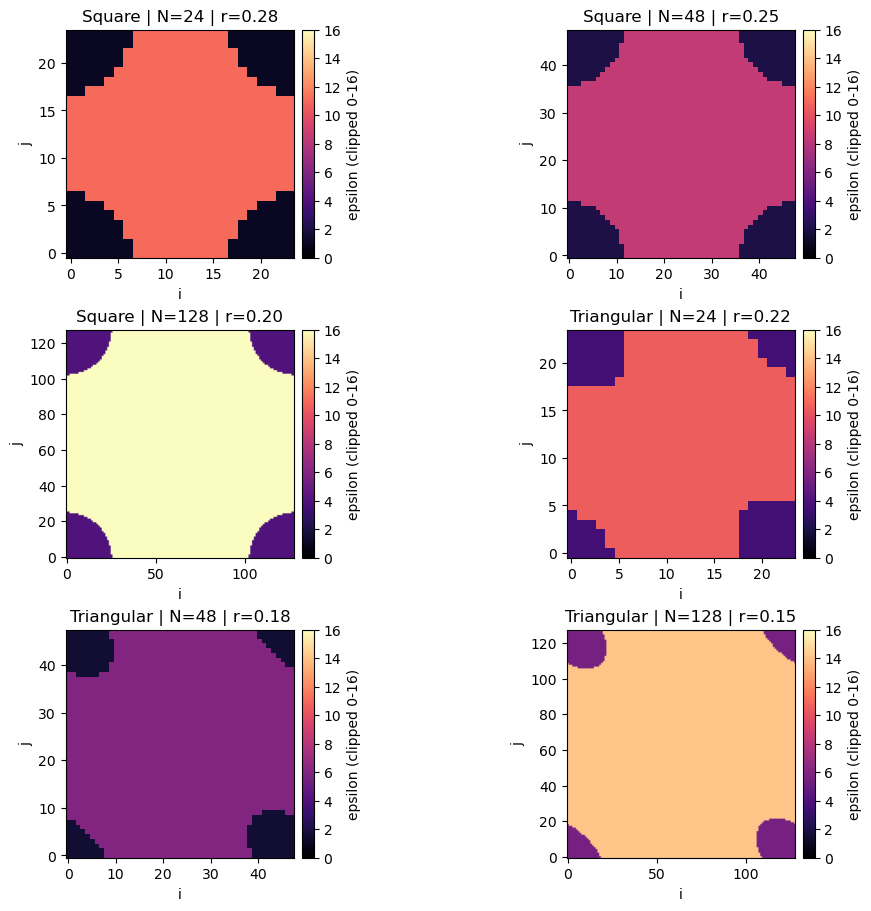

In [2]:
import matplotlib.pyplot as plt
import numpy as np

sorted_reports = sorted(reports, key=lambda r: (r['lattice'], r['resolution']))
cols = 2
rows = (len(sorted_reports) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows), constrained_layout=True)
axes = np.atleast_1d(axes).reshape(rows, cols)

for ax in axes.ravel():
    ax.axis('off')

for ax, report in zip(axes.ravel(), sorted_reports):
    grid = report['grid_array']
    im = ax.imshow(grid, cmap='magma', origin='lower', vmin=0.0, vmax=16.0)
    ax.set_title(
        f"{report['lattice'].title()} | N={report['resolution']} | r={report['radius_fractional']:.2f}"
    )
    ax.set_xlabel('i')
    ax.set_ylabel('j')
    cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label('epsilon (clipped 0-16)')
    ax.axis('on')

plt.show()

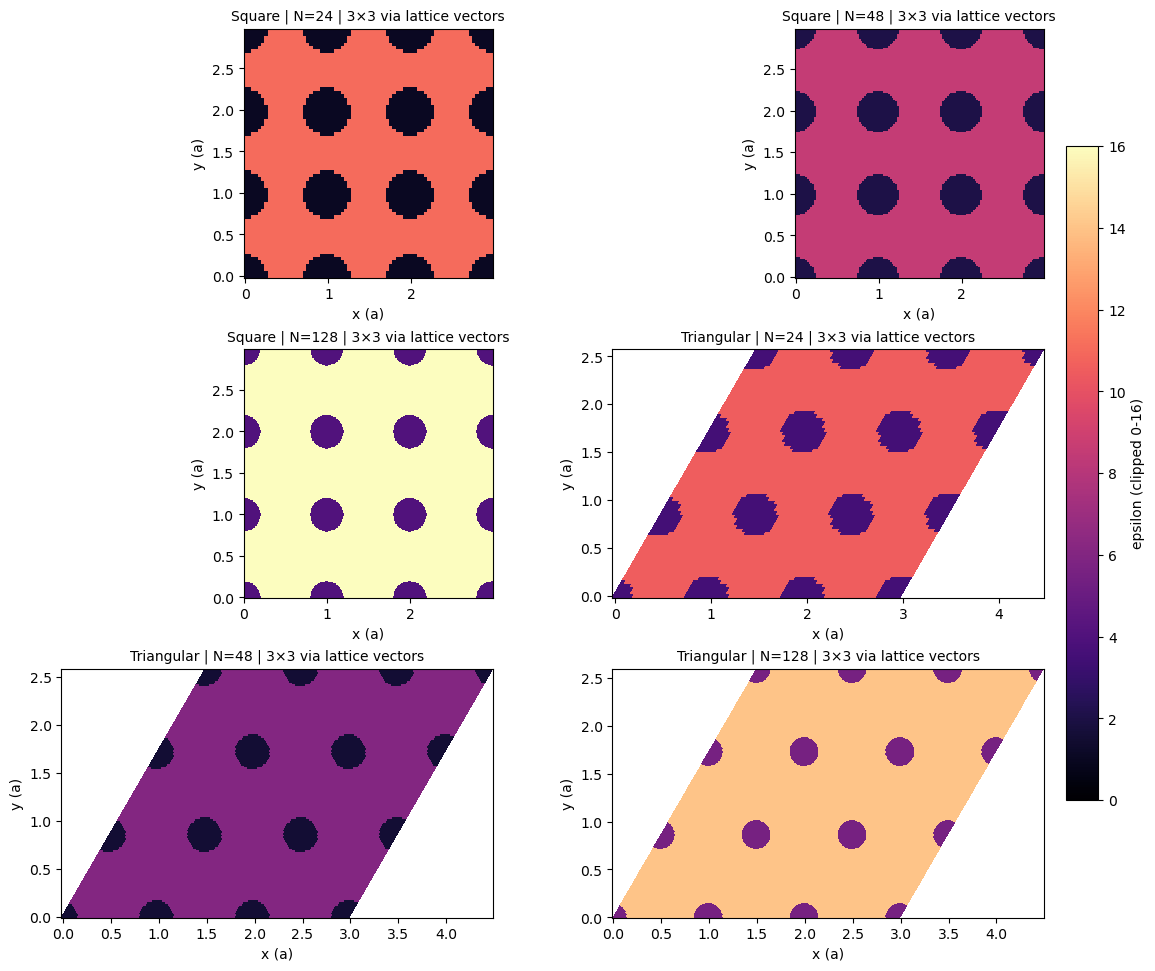

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

TILE_FACTOR = 3
LATTICE_VECTORS = {
    'square': (np.array([1.0, 0.0]), np.array([0.0, 1.0])),
    'triangular': (np.array([1.0, 0.0]), np.array([0.5, np.sqrt(3.0) / 2.0])),
}


def _base_coords(grid: np.ndarray, a1: np.ndarray, a2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ny, nx = grid.shape
    u = np.linspace(0.0, 1.0, nx, endpoint=False)
    v = np.linspace(0.0, 1.0, ny, endpoint=False)
    u_grid, v_grid = np.meshgrid(u, v)
    base_x = u_grid * a1[0] + v_grid * a2[0]
    base_y = u_grid * a1[1] + v_grid * a2[1]
    return base_x, base_y


def _tile_on_axis(ax, report: dict):
    grid = report['grid_array']
    a1, a2 = LATTICE_VECTORS.get(report['lattice'], LATTICE_VECTORS['square'])
    base_x, base_y = _base_coords(grid, a1, a2)
    shifts = [
        i * a1 + j * a2
        for i in range(TILE_FACTOR)
        for j in range(TILE_FACTOR)
    ]
    pcm = None
    for shift in shifts:
        pcm = ax.pcolormesh(
            base_x + shift[0],
            base_y + shift[1],
            grid,
            shading='nearest',
            cmap='magma',
            vmin=0.0,
            vmax=16.0,
        )
    ax.set_aspect('equal')
    ax.set_title(
        f"{report['lattice'].title()} | N={report['resolution']} | {TILE_FACTOR}×{TILE_FACTOR} via lattice vectors",
        fontsize=10,
    )
    ax.set_xlabel('x (a)')
    ax.set_ylabel('y (a)')
    ax.set_axis_on()
    return pcm

tiles = sorted_reports
cols = 2
rows = math.ceil(len(tiles) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, 3.2 * rows), constrained_layout=True)
axes = np.atleast_1d(axes).reshape(rows, cols)

for ax in axes.ravel():
    ax.axis('off')

pcms = []
for ax, report in zip(axes.ravel(), tiles):
    pcm = _tile_on_axis(ax, report)
    if pcm is not None:
        pcms.append(pcm)

if pcms:
    fig.colorbar(pcms[-1], ax=axes.ravel().tolist(), fraction=0.03, pad=0.02, label='epsilon (clipped 0-16)')

plt.show()

## Dielectric smoothing validation
The same canonical parameter tuples now feed a smoothing benchmark. Artifacts live under `artifacts/smoothing_data/` and were generated by `make smoothing-data`, which shells out to `mpb2d-validation -- smoothing-data …`. Each lattice/resolution/ε preset is swept across `mesh_size ∈ {1,4,12}` to quantify how sub-pixel averaging perturbs ε(r) and to ensure every configuration matches the Rust core outputs bit-for-bit.

In [4]:
SMOOTHING_DIR = NOTEBOOK_DIR / 'artifacts' / 'smoothing_data'
print(f'Reading smoothing reports from {SMOOTHING_DIR}')

def load_smoothing_reports():
    reports = []
    for path in sorted(SMOOTHING_DIR.glob('smoothing_*.json')):
        payload = json.loads(path.read_text())
        payload['artifact_path'] = path
        raw_grid = np.asarray(payload.pop('raw_grid'), dtype=float)
        payload['raw_grid_array'] = raw_grid
        smoothed = payload.get('smoothed_grid')
        if smoothed is not None:
            payload['smoothed_grid_array'] = np.asarray(smoothed, dtype=float)
        else:
            payload['smoothed_grid_array'] = None
        reports.append(payload)
    if not reports:
        raise FileNotFoundError(
'No smoothing validation JSON artifacts present. Run make smoothing-data first.'
        )
    return reports


smoothing_reports = load_smoothing_reports()
for payload in smoothing_reports:
    shape = (payload['resolution'], payload['resolution'])
    assert payload['raw_grid_array'].shape == shape, f"Raw grid shape mismatch for {payload['artifact_path']}"
    if payload['smoothed_grid_array'] is not None:
        assert payload['smoothed_grid_array'].shape == shape, f"Smoothed grid shape mismatch for {payload['artifact_path']}"

def _get(optional_dict, key):
    return None if optional_dict is None else optional_dict.get(key)

smoothing_summary = pd.DataFrame({
    'lattice': [p['lattice'] for p in smoothing_reports],
    'resolution': [p['resolution'] for p in smoothing_reports],
    'mesh_size': [p['mesh_size'] for p in smoothing_reports],
    'eps_bg': [p['eps_bg'] for p in smoothing_reports],
    'eps_inside': [p['eps_inside'] for p in smoothing_reports],
    'raw_min': [p['raw_stats']['min'] for p in smoothing_reports],
    'raw_max': [p['raw_stats']['max'] for p in smoothing_reports],
    'raw_mean': [p['raw_stats']['mean'] for p in smoothing_reports],
    'smoothed_mean': [_get(p.get('smoothed_stats'), 'mean') for p in smoothing_reports],
    'delta_max': [_get(p.get('delta_stats'), 'max_abs') for p in smoothing_reports],
    'delta_l2': [_get(p.get('delta_stats'), 'l2_norm') for p in smoothing_reports],
    'artifact': [str(p['artifact_path']) for p in smoothing_reports],
}).sort_values(['lattice', 'resolution', 'mesh_size']).reset_index(drop=True)

display(
    smoothing_summary.style.format({
        'raw_min': '{:.3f}',
        'raw_max': '{:.3f}',
        'raw_mean': '{:.3f}',
        'smoothed_mean': '{:.3f}',
        'delta_max': '{:.4f}',
        'delta_l2': '{:.4f}',
    })
)

Reading smoothing reports from /home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data


,lattice,resolution,mesh_size,eps_bg,eps_inside,raw_min,raw_max,raw_mean,smoothed_mean,delta_max,delta_l2,artifact
0,square,24,1,11.000000,1.000000,1.000,11.000,8.431,nan,nan,nan,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res24_bg11p0_hole1p0_mesh1.json
1,square,24,4,11.000000,1.000000,1.000,11.000,8.431,8.522,4.3750,0.7310,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res24_bg11p0_hole1p0_mesh4.json
2,square,24,12,11.000000,1.000000,1.000,11.000,8.431,8.536,4.5833,0.7831,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res24_bg11p0_hole1p0_mesh12.json
3,square,48,1,8.500000,2.000000,2.000,8.500,7.236,nan,nan,nan,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res48_bg8p5_hole2p0_mesh1.json
4,square,48,4,8.500000,2.000000,2.000,8.500,7.236,7.225,2.8438,0.3075,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res48_bg8p5_hole2p0_mesh4.json
5,square,48,12,8.500000,2.000000,2.000,8.500,7.236,7.223,3.0694,0.3170,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res48_bg8p5_hole2p0_mesh12.json
6,square,128,1,16.000000,4.000000,4.000,16.000,14.494,nan,nan,nan,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res128_bg16p0_hole4p0_mesh1.json
7,square,128,4,16.000000,4.000000,4.000,16.000,14.494,14.493,6.0000,0.3830,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res128_bg16p0_hole4p0_mesh4.json
8,square,128,12,16.000000,4.000000,4.000,16.000,14.494,14.492,5.6667,0.3649,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_square_res128_bg16p0_hole4p0_mesh12.json
9,triangular,24,1,10.500000,3.500000,3.500,10.500,9.236,nan,nan,nan,/home/renlephy/mpb-gpu-2D/python/validation/artifacts/smoothing_data/smoothing_triangular_res24_bg10p5_hole3p5_mesh1.json


/tmp/ipykernel_23024/3406793214.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


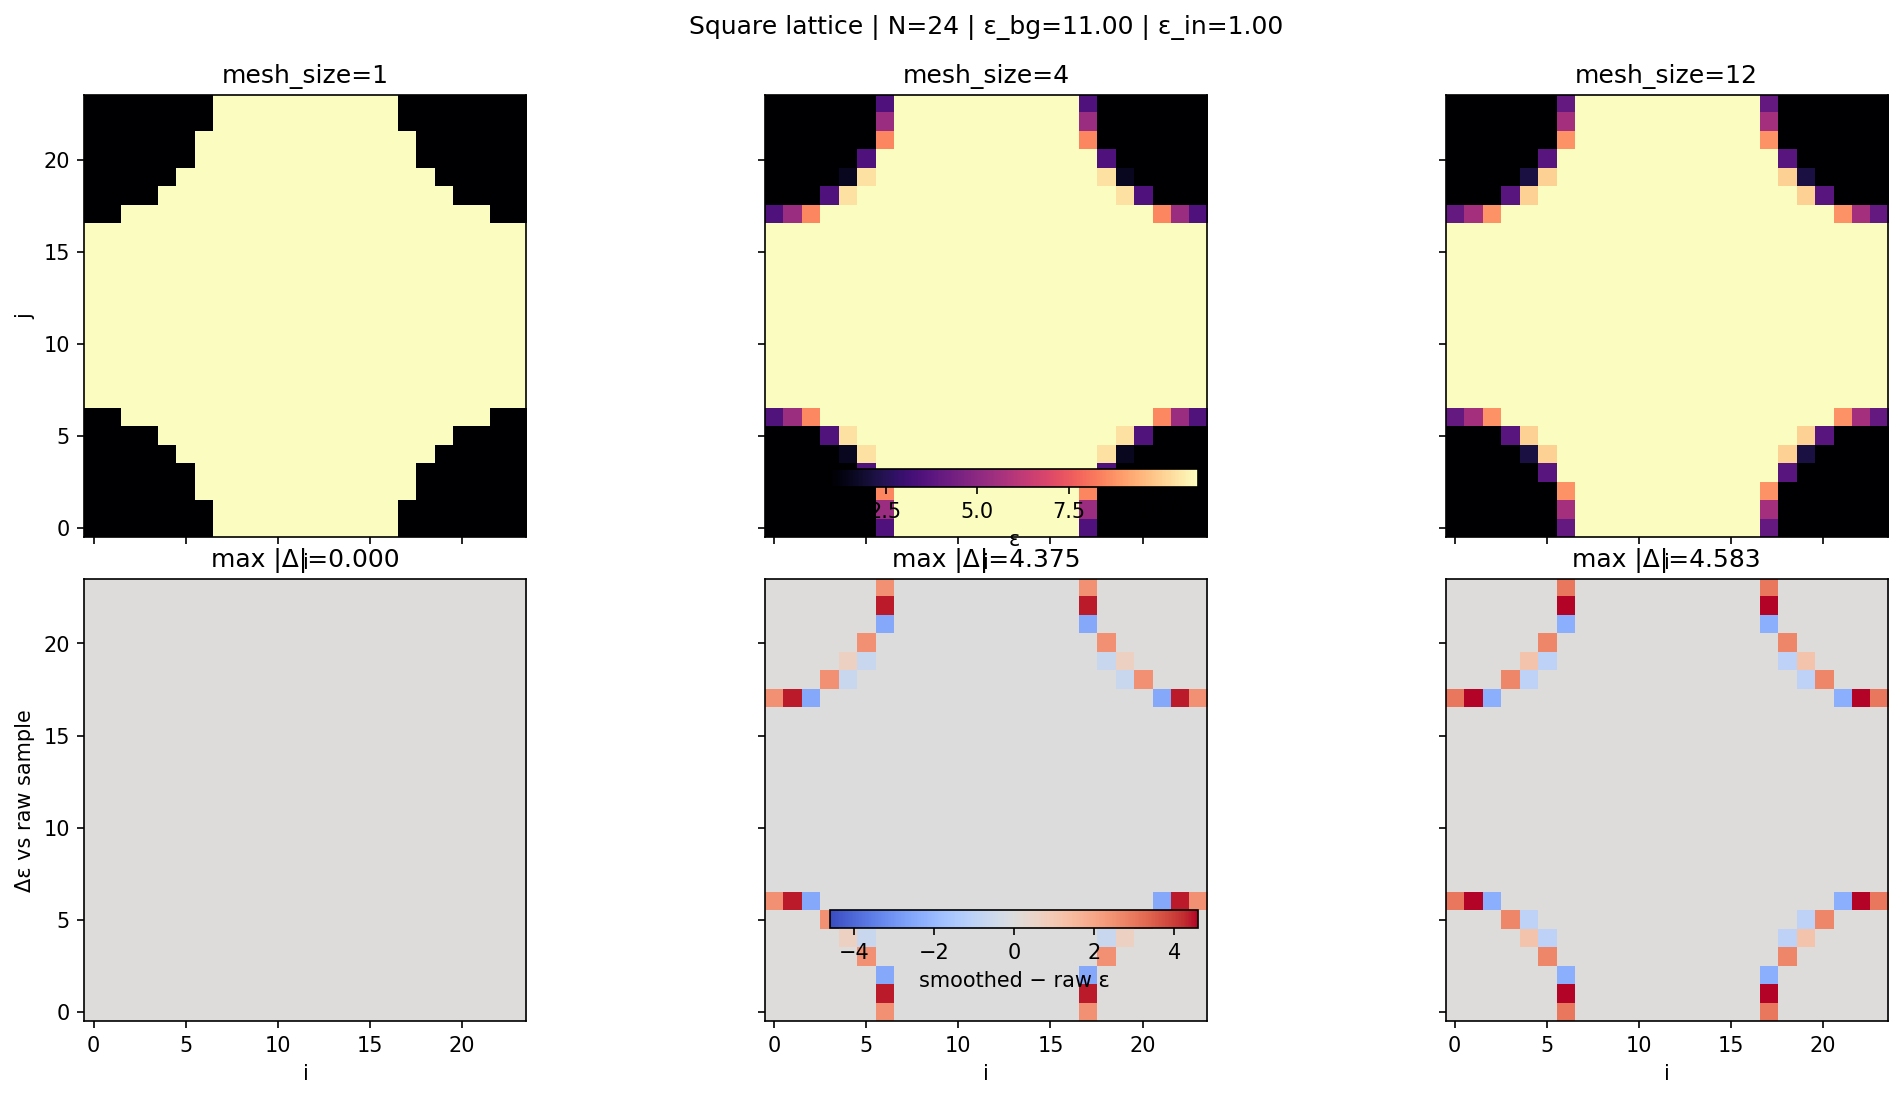

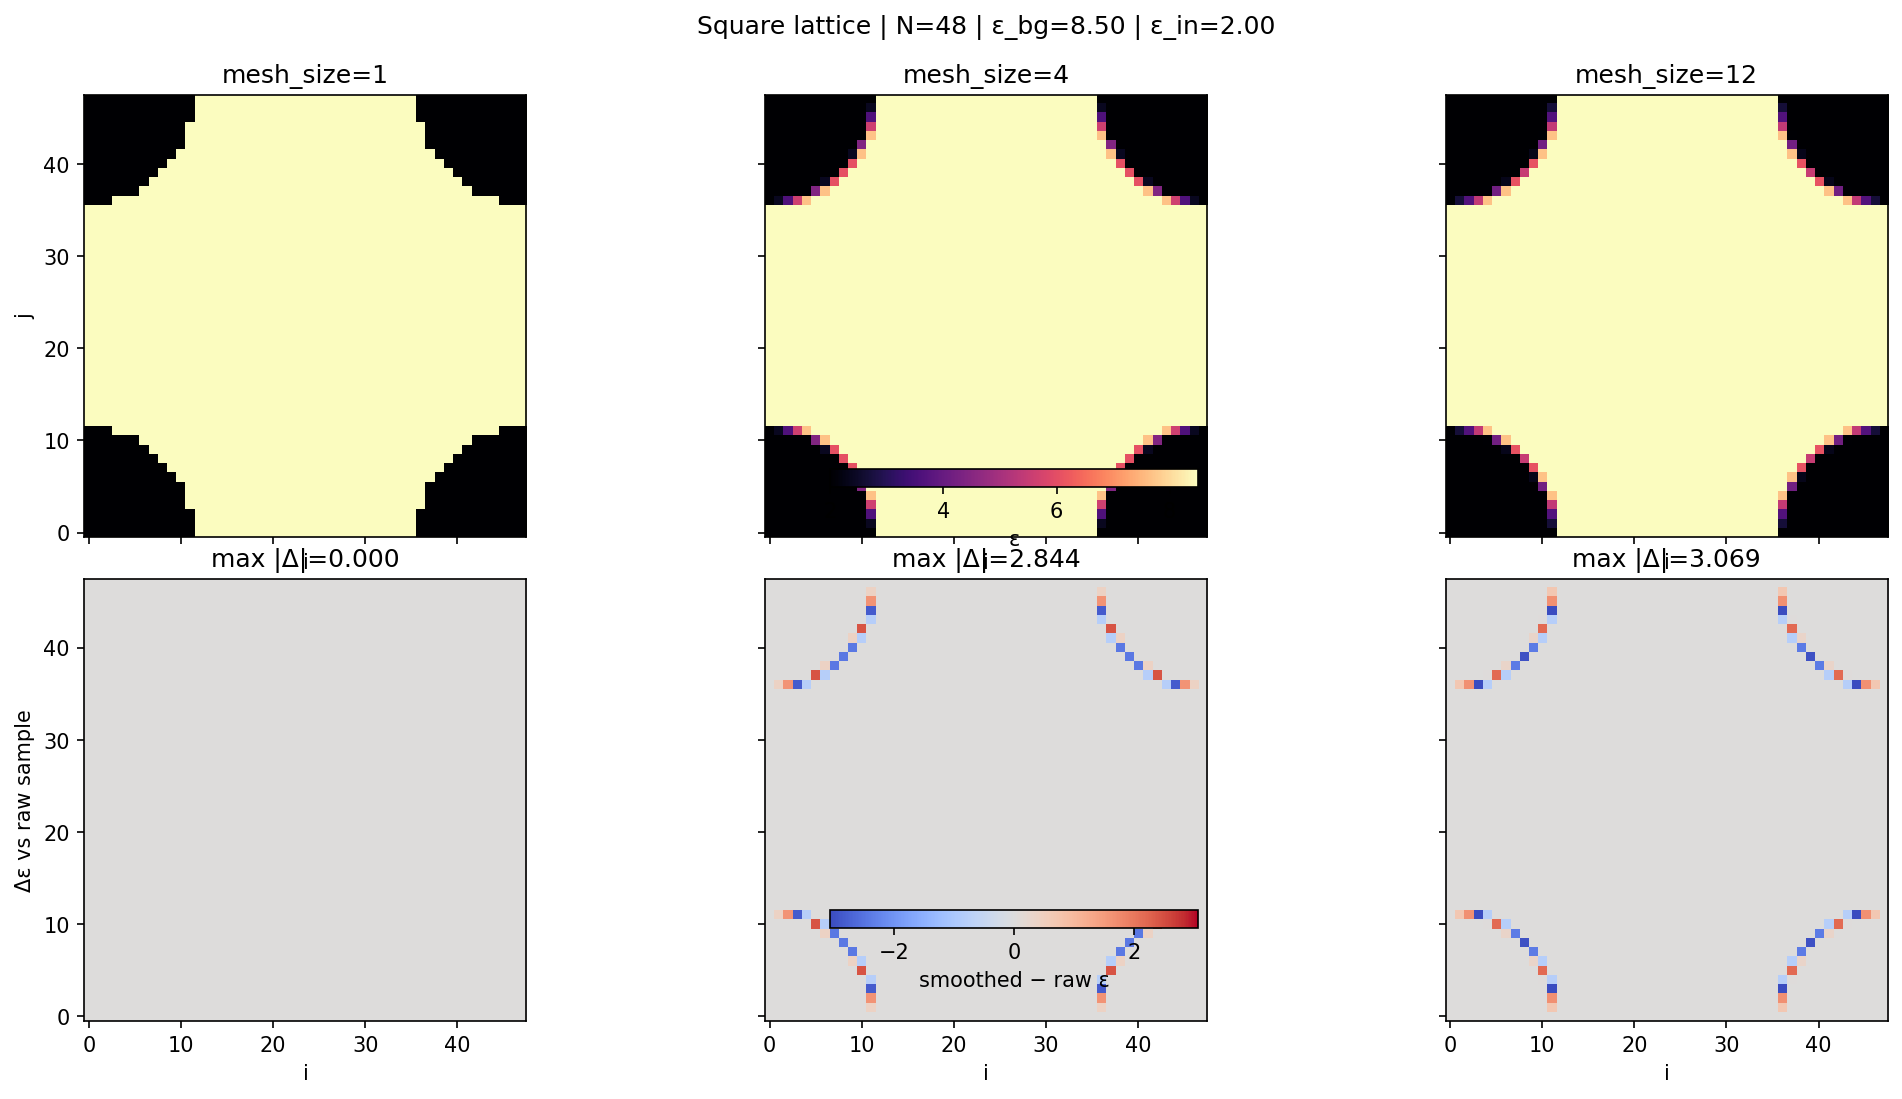

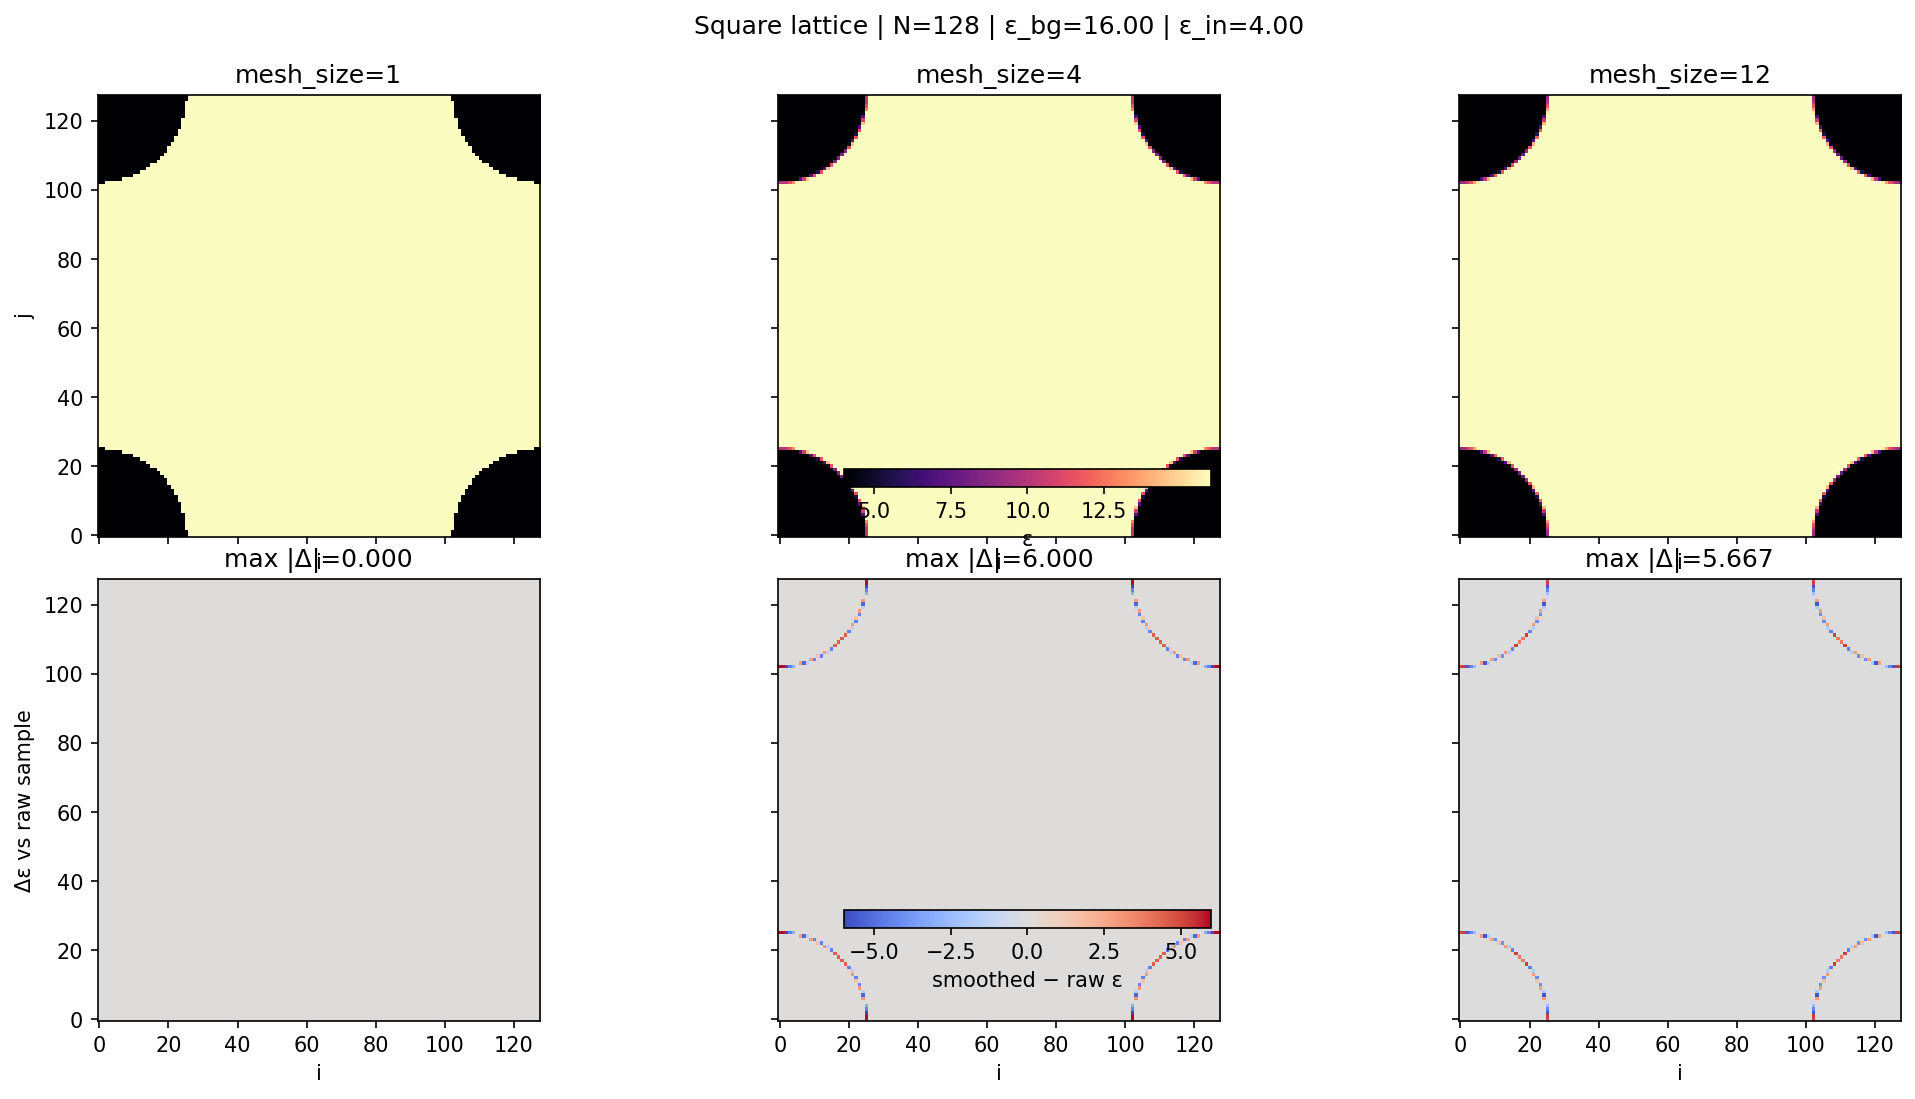

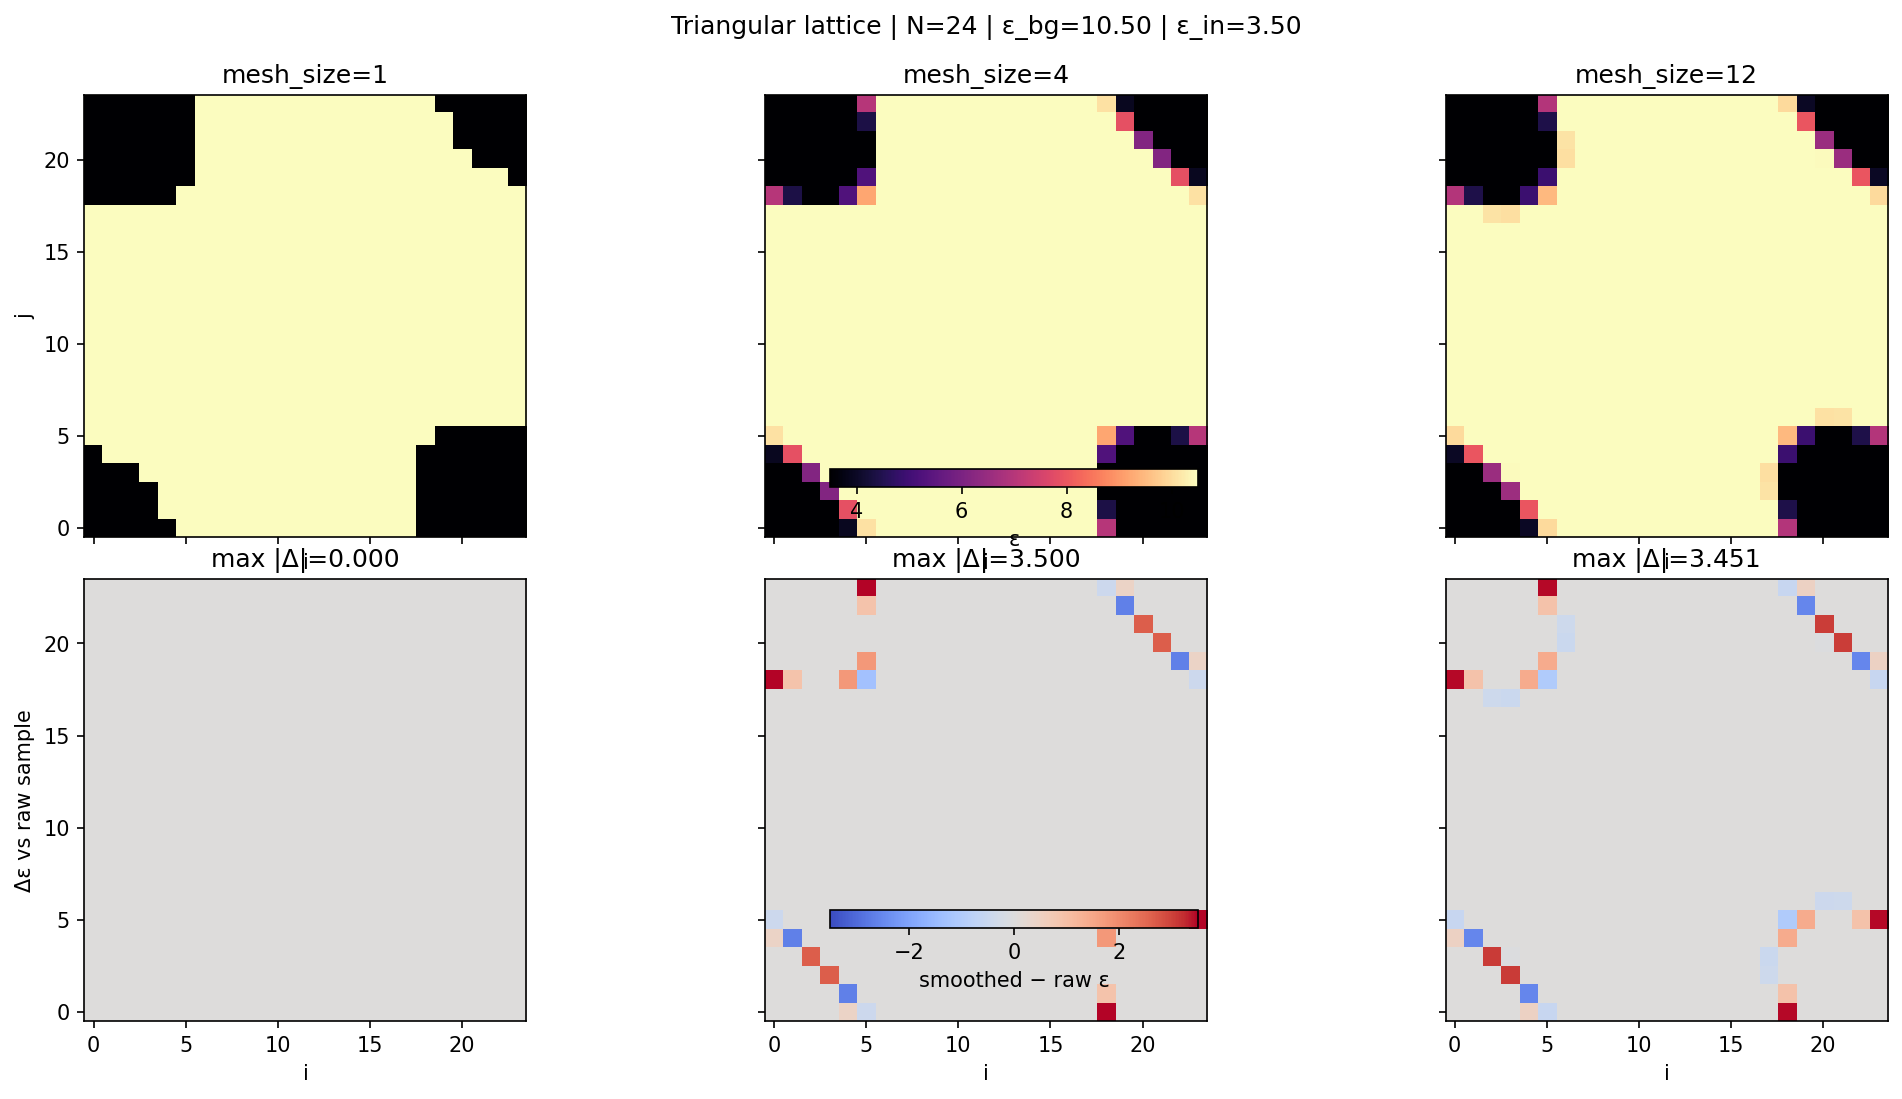

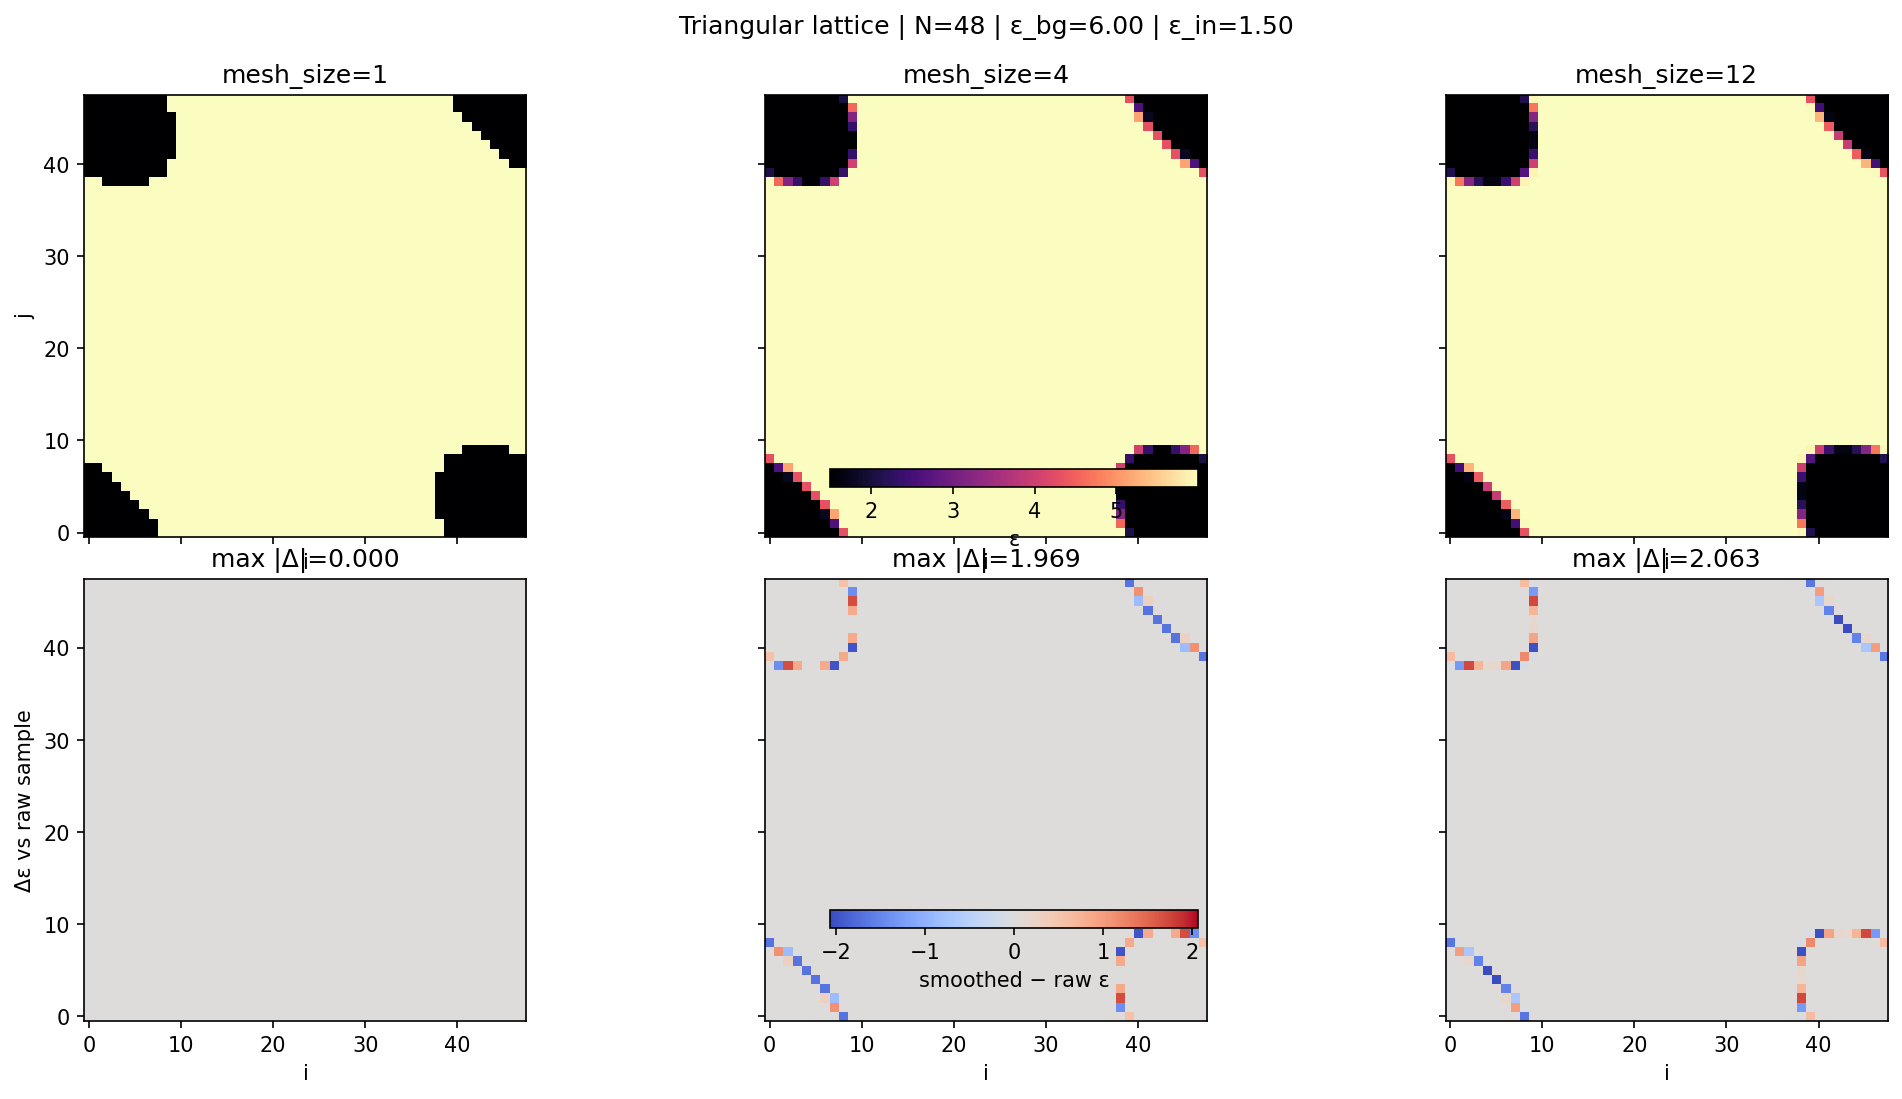

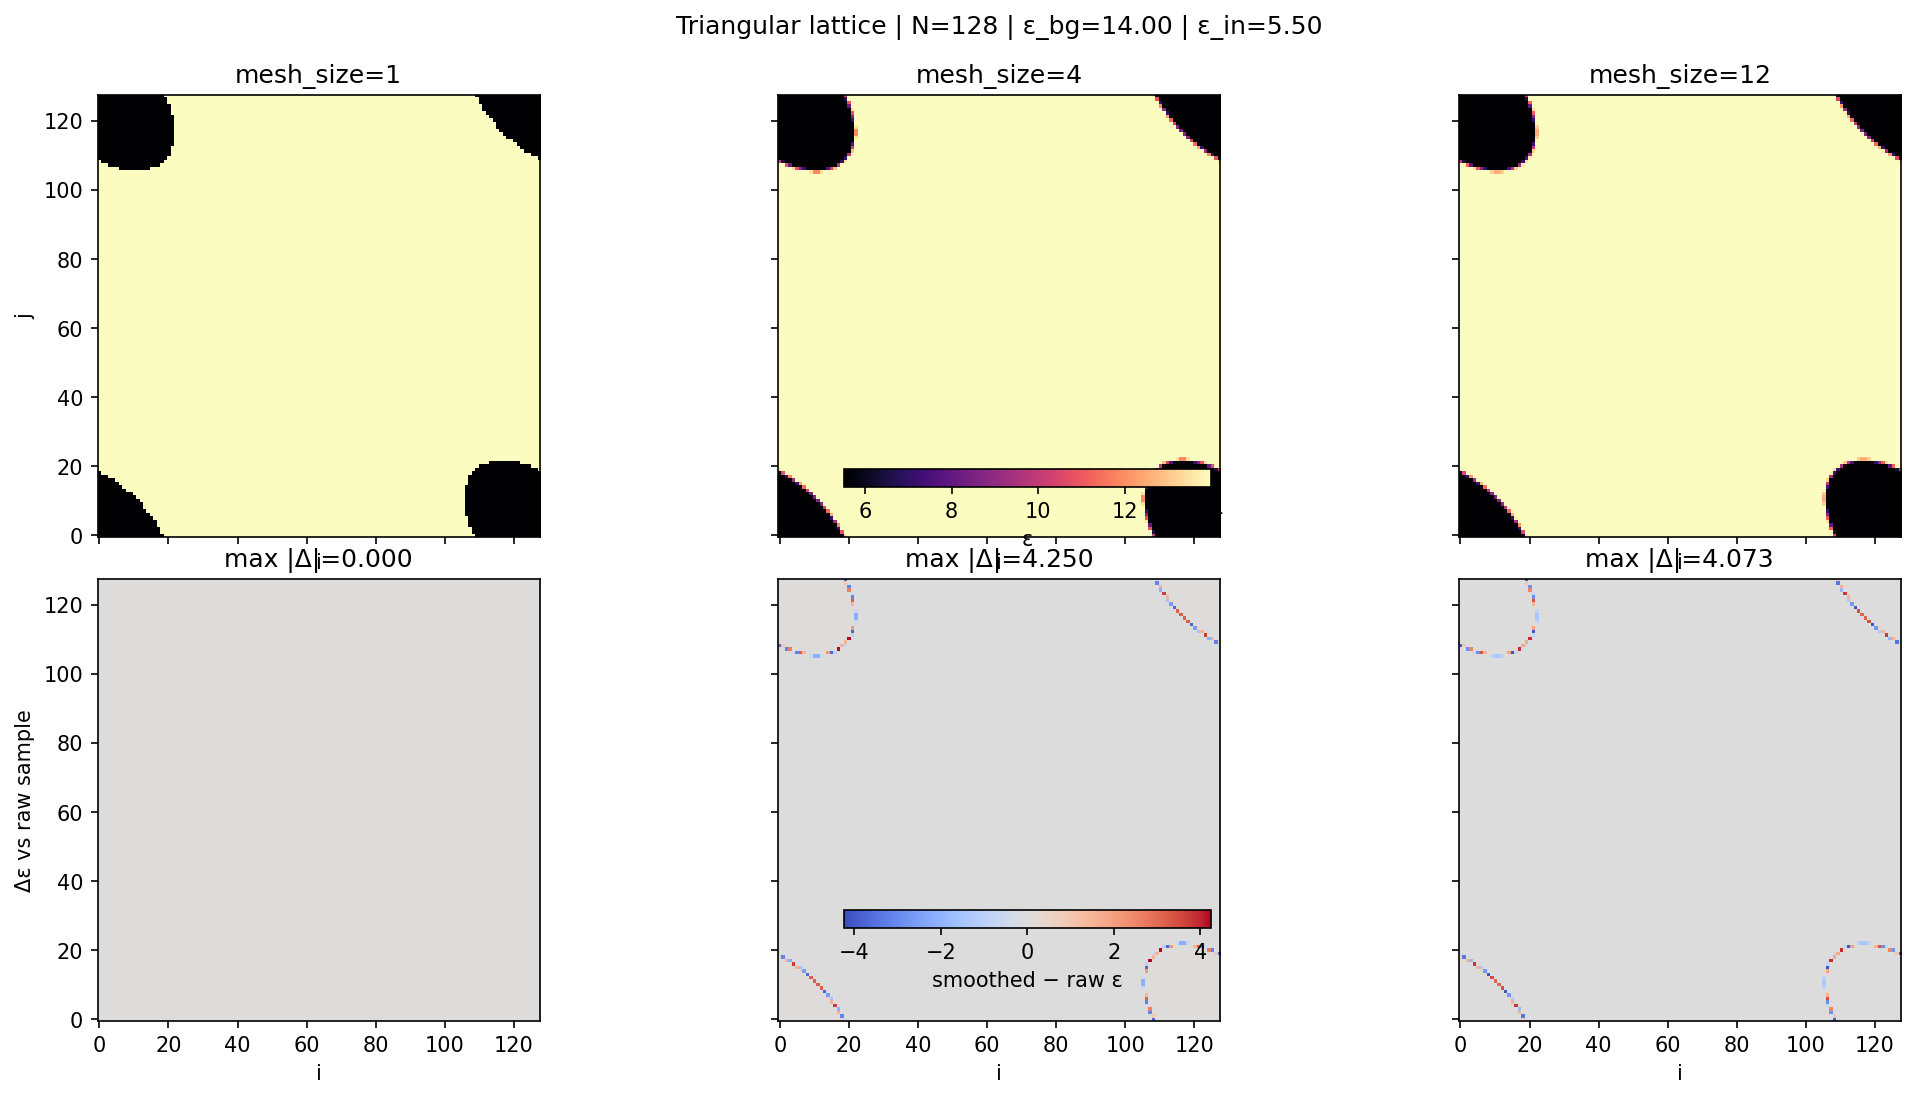

In [5]:
from collections import defaultdict
MESH_COLUMNS = [1, 4, 12]

grouped_configs = defaultdict(list)
for payload in smoothing_reports:
    key = (
        payload['lattice'],
        payload['resolution'],
        payload['eps_bg'],
        payload['eps_inside'],
    )
    grouped_configs[key].append(payload)

def _format_config_title(key):
    lattice, resolution, eps_bg, eps_inside = key
    return (
        f"{lattice.title()} lattice | N={resolution} | "
        f"ε_bg={eps_bg:.2f} | ε_in={eps_inside:.2f}"
    )

for key in sorted(grouped_configs.keys()):
    entries = grouped_configs[key]
    mesh_map = {entry['mesh_size']: entry for entry in entries}
    delta_arrays = []
    for entry in entries:
        grid = entry['smoothed_grid_array'] if entry['smoothed_grid_array'] is not None else entry['raw_grid_array']
        delta_arrays.append(grid - entry['raw_grid_array'])
    diff_lim = max((np.max(np.abs(delta)) for delta in delta_arrays), default=0.0)
    diff_lim = max(diff_lim, 1e-6)

    fig, axes = plt.subplots(
        2,
        len(MESH_COLUMNS),
        figsize=(5 * len(MESH_COLUMNS), 7),
        dpi=150,
        sharex=True,
        sharey=True,
    )
    for ax in axes.ravel():
        ax.set_aspect('equal')

    im_handle = None
    pcm_handle = None
    for col_idx, mesh_size in enumerate(MESH_COLUMNS):
        main_ax = axes[0, col_idx]
        delta_ax = axes[1, col_idx]
        payload = mesh_map.get(mesh_size)
        if payload is None:
            main_ax.text(0.5, 0.5, f'mesh_size={mesh_size}\nnot available', ha='center', va='center')
            main_ax.set_axis_off()
            delta_ax.text(0.5, 0.5, 'no data', ha='center', va='center')
            delta_ax.set_axis_off()
            continue

        grid = payload['smoothed_grid_array'] if payload['smoothed_grid_array'] is not None else payload['raw_grid_array']
        im_handle = main_ax.imshow(grid, origin='lower', cmap='magma')
        main_ax.set_title(f'mesh_size={mesh_size}')
        main_ax.set_xlabel('i')
        if col_idx == 0:
            main_ax.set_ylabel('j')

        delta = grid - payload['raw_grid_array']
        pcm_handle = delta_ax.imshow(delta, origin='lower', cmap='coolwarm', vmin=-diff_lim, vmax=diff_lim)
        delta_ax.set_xlabel('i')
        if col_idx == 0:
            delta_ax.set_ylabel('Δε vs raw sample')
        delta_ax.set_title(f"max |Δ|={np.abs(delta).max():.3f}")

    fig.suptitle(_format_config_title(key))
    if im_handle is not None:
        fig.colorbar(
            im_handle,
            ax=axes[0, :],
            orientation='horizontal',
            fraction=0.05,
            pad=0.08,
            label='ε',
        )
    if pcm_handle is not None:
        fig.colorbar(
            pcm_handle,
            ax=axes[1, :],
            orientation='horizontal',
            fraction=0.05,
            pad=0.2,
            label='smoothed − raw ε',
        )
    fig.tight_layout()
    plt.show()